In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Single-layer vanilla RNN for finding ground state of pairing-model

In [2]:
class Model(nn.Module):
     
    def __init__(self, hidden_size, vector_size):
        super().__init__()
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size, vector_size)
        
        self.hidden_initial = nn.Parameter(torch.empty(1, hidden_size).normal_(mean=0, std=1))
        self.hidden_current = torch.Tensor(self.hidden_initial)
              
    def forward(self):
        self.hidden_current = torch.tanh(self.Whh(self.hidden_current))
        y = self.Why(self.hidden_current)
        
        return y
    
    def hidden_reset(self):
        self.hidden_current = torch.Tensor(self.hidden_initial)

In [3]:
dim = 6

delta = 1
g = 0.5


H = np.array([[2*delta - g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0],
              [-0.5*g, 4*delta - g, -0.5*g, -0.5*g, 0, -0.5*g],
              [-0.5*g, -0.5*g, 6*delta - g, 0, -0.5*g, -0.5*g],
              [-0.5*g, -0.5*g, 0, 6*delta - g, -0.5*g, -0.5*g],
              [-0.5*g, 0, -0.5*g, -0.5*g, 8*delta - g, -0.5*g],
              [0, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta - g]])

eig, eigvec = np.linalg.eig(H)
eigvec = -eigvec[:,0]
print(eig)
print(eigvec)
A = torch.Tensor(-H)

[1.41677428 3.47067322 5.5        7.54943676 9.56311574 5.5       ]
[0.98419512 0.13663267 0.07210914 0.07210914 0.04679042 0.01013337]


In [4]:
s = np.linspace(0, 0.5, 15)
ds = s[1] - s[0]

In [5]:
torch.manual_seed(42)
np.random.seed(42)
model = Model(30, dim)

optimizer = torch.optim.Adam(model.parameters())

In [6]:
epochs = 10000
mu = 0.0000
for epoch in range(epochs):
    loss = 0
    L2 = 0
    x_prev = torch.zeros(1, dim)
    x_prev[0, 0] = 1
    model.hidden_reset()
    x = model()
    
    for i in range(1, len(s)):  
        x_next = model()
        
        LHS = (x_next - x_prev)/(2*ds)
        
        
        Ax = torch.mv(A, x[0])
        RHS = Ax - torch.dot(x[0], Ax)*x[0]
        
        loss += torch.mean((LHS - RHS)**2)

        x_prev = x
        x = x_next
        
    loss /= len(s) - 1
    
    num_param = 0
    for param in model.parameters():
        L2 += torch.sum(param**2)
        num_param += np.prod(param.size())
    
    loss += mu*L2
    
    if epoch%500 == 0:
        print(f"epoch: {epoch}, loss: {loss.item(): .6f}, L2: {mu*L2: .6f}")

    optimizer.zero_grad()   
    loss.backward()
    optimizer.step()
    
    

epoch: 0, loss:  4.375743, L2:  0.000000
epoch: 500, loss:  0.002316, L2:  0.000000
epoch: 1000, loss:  0.000138, L2:  0.000000
epoch: 1500, loss:  0.000042, L2:  0.000000
epoch: 2000, loss:  0.000026, L2:  0.000000
epoch: 2500, loss:  0.000021, L2:  0.000000
epoch: 3000, loss:  0.000017, L2:  0.000000
epoch: 3500, loss:  0.000014, L2:  0.000000
epoch: 4000, loss:  0.000119, L2:  0.000000
epoch: 4500, loss:  0.000010, L2:  0.000000
epoch: 5000, loss:  0.000008, L2:  0.000000
epoch: 5500, loss:  0.000009, L2:  0.000000
epoch: 6000, loss:  0.000007, L2:  0.000000
epoch: 6500, loss:  0.000004, L2:  0.000000
epoch: 7000, loss:  0.000008, L2:  0.000000
epoch: 7500, loss:  0.000004, L2:  0.000000
epoch: 8000, loss:  0.000003, L2:  0.000000
epoch: 8500, loss:  0.000006, L2:  0.000000
epoch: 9000, loss:  0.000002, L2:  0.000000
epoch: 9500, loss:  0.000017, L2:  0.000000


-1.5153629


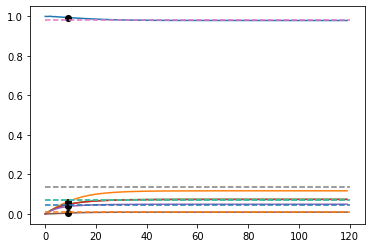

In [18]:
x = torch.zeros(1, dim)
x[0, 0] = 1
x_array = [x[0].detach().numpy()]
model.hidden_reset()

hidden_array = [model.hidden_current[0].detach().numpy()]

for i in range(1, 120):
    x = model()  
    x_array.append(x[0].detach().numpy())
    hidden_array.append(model.hidden_current[0].detach().numpy())

x_array = np.array(x_array)
hidden_array = np.array(hidden_array)

print(-x_array[-1]@A.detach().numpy()@x_array[-1]/(x_array[-1]@x_array[-1]))

plt.plot(x_array)
plt.plot(9*np.ones(dim), x_array[9], "ko")
plt.plot((0, 120), (eigvec, eigvec), "--")
#plt.ylim(0,0.2)
plt.show()

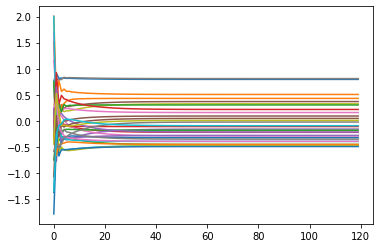

In [8]:
plt.plot(hidden_array)
plt.show()

### SRG

In [14]:
def com(A,B):
    return torch.mm(A, B) - torch.mm(B, A)

In [15]:
s = np.linspace(0, 0.2, 10)
ds = s[1] - s[0]

In [16]:
torch.manual_seed(42)
np.random.seed(42)
model2 = Model(50, 36)

optimizer = torch.optim.Adam(model2.parameters())

In [17]:
epochs = 11500
for epoch in range(epochs):
    loss = 0
    x_prev = torch.Tensor(H).reshape(1,-1)
    model2.hidden_reset()   
    
    for i in range(1, len(s)):  
        x = model2()
        
        LHS = (x - x_prev)/ds
        
        x_mid = (x + x_prev)/2
        x_mid = x_mid.reshape(6,6)
        
        A = torch.diag(torch.diag(x_mid))
        B = x_mid - A
        
        RHS = com(com(A,B), x_mid).reshape(1, -1)
        
        loss += torch.mean((LHS - RHS)**2)

        x_prev = x
        
    loss /= len(s) - 1
    

    
    if epoch%500 == 0:
        print(f"epoch: {epoch}, loss: {loss.item()}")

    optimizer.zero_grad()   
    loss.backward()
    optimizer.step()

epoch: 0, loss: 1400.7921142578125
epoch: 500, loss: 0.6104878783226013
epoch: 1000, loss: 0.4798615872859955
epoch: 1500, loss: 0.24258872866630554
epoch: 2000, loss: 0.09222619980573654
epoch: 2500, loss: 0.04774982109665871
epoch: 3000, loss: 0.03654547780752182
epoch: 3500, loss: 0.03106384165585041
epoch: 4000, loss: 0.02473379671573639
epoch: 4500, loss: 0.016076013445854187
epoch: 5000, loss: 0.010668816044926643
epoch: 5500, loss: 0.0077203139662742615
epoch: 6000, loss: 0.006307604257017374
epoch: 6500, loss: 0.005036402028053999
epoch: 7000, loss: 0.0043840669095516205
epoch: 7500, loss: 0.0031752586364746094
epoch: 8000, loss: 0.00843963772058487
epoch: 8500, loss: 0.007291742600500584
epoch: 9000, loss: 0.009582290425896645
epoch: 9500, loss: 0.0044311159290373325
epoch: 10000, loss: 0.001817992771975696
epoch: 10500, loss: 0.001974893268197775
epoch: 11000, loss: 0.0010842779884114861


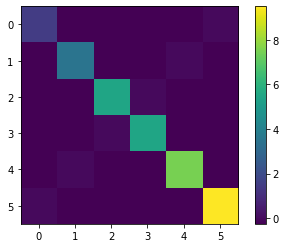

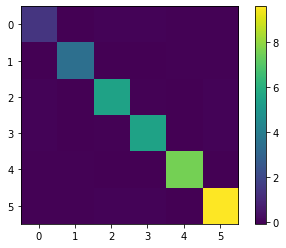

[1.41560876 3.46960473 5.50264311 5.50300837 7.55580521 9.56824589]
[1.41677428 3.47067322 5.5        7.54943676 9.56311574 5.5       ]


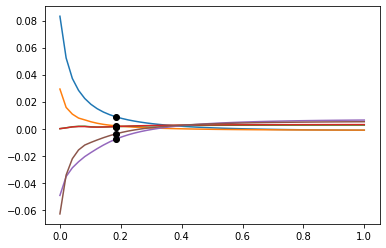

In [13]:
x = torch.Tensor(H).reshape(1,-1)
x_array = [x[0].detach().numpy()]

eigenvalues = [np.diag(H)]

model2.hidden_reset()
for i in range(1, 50):
    x = model2()  
    x_array.append(x[0].detach().numpy())
    eigenvalues.append(np.diag(x.reshape(6, 6).detach().numpy()))

eigenvalues = np.array(eigenvalues)
    
h_diag = x_array[-1].reshape(6,6)

plt.imshow(H)
plt.colorbar()
plt.show()

plt.imshow(h_diag)
plt.colorbar()
plt.show()

print(eigenvalues[-1])
print(eig)

s = np.linspace(0, 1, 50)
plt.plot(s, eigenvalues - np.sort(eig))
plt.plot(s[9]*np.ones(6), (eigenvalues - np.sort(eig))[9], "ko")
plt.show()

# Continous RNN (ODE-net type)

In [3]:
A = np.random.normal(0,1,(16, 16))
A = (A + A.T)/2

In [ ]:
class Model(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(17, 4)
        self.layer2 = nn.Linear(4, 4)
        self.layer3 = nn.Linear(4, 16)
              
    def forward(self):
        self.hidden_current = torch.tanh(self.Whh(self.hidden_current))
        y = self.Why(self.hidden_current)
        
        return y
    
    def hidden_reset(self):
        self.hidden_current = torch.Tensor(self.hidden_initial)